<a href="https://colab.research.google.com/github/SFStefenon/synthetic_ED/blob/main/gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

device: cpu
18


Image size: (1, 28, 28)
--- Label ---
label
44     855
54     406
65     379
75     343
102    329
      ... 
35       1
18       1
71       1
19       1
24       1
Name: count, Length: 85, dtype: int64
[ 0/10][      0][    1.20s]	d_loss/g_loss:  0.3/0.029	
[ 1/10][      1][    2.66s]	d_loss/g_loss: -1.9/0.068	
[ 2/10][      2][    4.91s]	d_loss/g_loss: -3.7/0.54	
[ 3/10][      3][    5.88s]	d_loss/g_loss: -3.3/0.21	
[ 4/10][      4][    6.83s]	d_loss/g_loss: 0.42/0.38	
[ 5/10][      5][    7.79s]	d_loss/g_loss:  5.0/0.35	
[ 6/10][      6][    8.75s]	d_loss/g_loss: -4.9/0.54	
[ 7/10][      7][    9.72s]	d_loss/g_loss: -8.0/ 1.0	
[ 8/10][      8][   10.68s]	d_loss/g_loss: -8.1/ 1.3	
[ 9/10][      9][   11.64s]	d_loss/g_loss: -6.0/0.99	
14.64715027809143


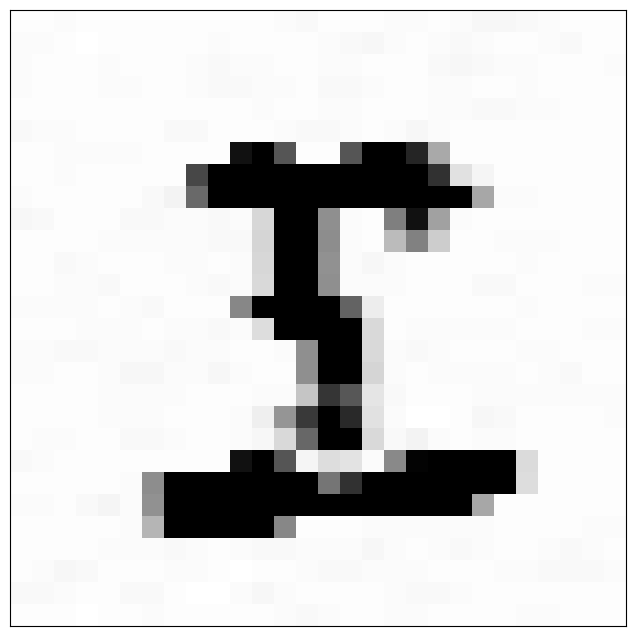

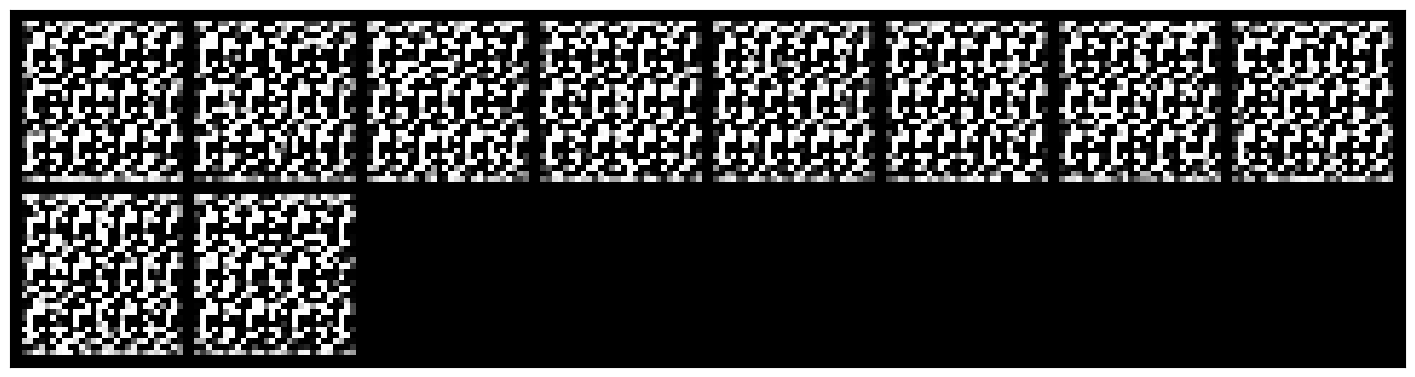

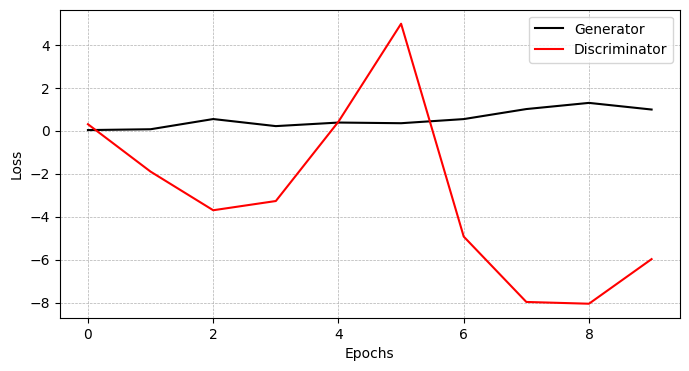

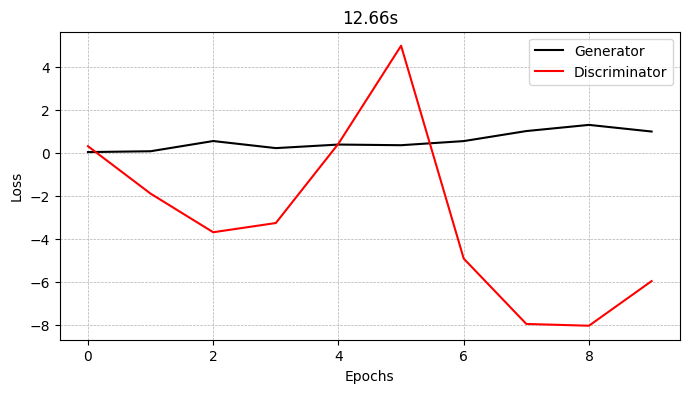

In [ ]:
import torch
from torch import nn, optim, autograd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from dataclasses import dataclass
import time
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
from torchvision.utils import make_grid
torch.set_num_threads(1)
torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

# Define the storage and dataset path
storage = ''
train_data_path = '28by28_rfi_train_perfect.csv'
save_by_epoch = False

@dataclass
class Hyperparameter:
    num_classes: int        = 1
    samples_for_class: int  = 10
    batchsize: int          = 1
    num_epochs: int         = 10 # 5000
    latent_size: int        = 64
    n_critic: int           = 5
    critic_size: int        = 1024
    generator_size: int     = 1024
    critic_hidden_size: int = 1024
    gp_lambda: float        = 10.
hp = Hyperparameter()
img_size = 28

start = time.time()
for classes in range(18,19):
  print(classes)
  if any(pd.read_csv(train_data_path).label.values==int(classes)): # Check if the class exists
    considered_label = int(classes)
    class_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'AD', 'AU', 'C00', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56']
    class_list = class_list[considered_label]

    class RFI(Dataset):
        def __init__(self, path, img_size, c_label=considered_label, transform=None):
            self.transform = transform
            rfi_df = pd.read_csv(path)
            images = rfi_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
            self.images = images[np.where(rfi_df.label.values==c_label)]
            self.labels = rfi_df.label.values[np.where(rfi_df.label.values==c_label)]
            print('Image size:', self.images.shape)
            print('--- Label ---')
            print(rfi_df.label.value_counts())
        def __len__(self):
            return len(self.images)
        def __getitem__(self, idx):
            label = self.labels[idx]
            img = self.images[idx]
            img = Image.fromarray(self.images[idx])
            if self.transform:
                img = self.transform(img)
            return img, label
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
    dataset = RFI(train_data_path, img_size, considered_label, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=hp.batchsize, shuffle=True, drop_last=True)

    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(12,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        figure_name = str(storage) + 'R_GAN_class_' + str(classes) + '_image_original.pdf'
        plt.savefig(figure_name)
        break

    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.latent_embedding = nn.Sequential(nn.Linear(hp.latent_size, hp.generator_size),)
            self.tcnn = nn.Sequential(
            nn.ConvTranspose2d(hp.generator_size, hp.generator_size, 4, 1, 0),
            nn.BatchNorm2d(hp.generator_size),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hp.generator_size, hp.generator_size // 2, 3, 2, 1),
            nn.BatchNorm2d(hp.generator_size // 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hp.generator_size // 2, hp.generator_size // 4, 4, 2, 1),
            nn.BatchNorm2d(hp.generator_size // 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hp.generator_size // 4, 1, 4, 2, 1),
            nn.Tanh())

        def forward(self, latent):
            vec_latent = self.latent_embedding(latent).reshape(-1, hp.generator_size, 1, 1)
            return self.tcnn(vec_latent)

    class Critic(nn.Module):
        def __init__(self):
            super(Critic, self).__init__()
            self.cnn_net = nn.Sequential(
            nn.Conv2d(1, hp.critic_size // 4, 3, 2),
            nn.InstanceNorm2d(hp.critic_size // 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hp.critic_size // 4, hp.critic_size // 2, 3, 2),
            nn.InstanceNorm2d(hp.critic_size // 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hp.critic_size // 2, hp.critic_size, 3, 2),
            nn.InstanceNorm2d(hp.critic_size, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),)
            self.critic_net = nn.Sequential(
            nn.Linear(hp.critic_size * 4, hp.critic_hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hp.critic_hidden_size, 1),)

        def forward(self, image):
            cnn_features = self.cnn_net(image)
            return self.critic_net(cnn_features)

    critic, generator = Critic().to(device), Generator().to(device)
    critic_optimizer = optim.AdamW(critic.parameters(), lr=1e-4,betas=(0., 0.9))
    generator_optimizer = optim.AdamW(generator.parameters(), lr=1e-4,betas=(0., 0.9))
    img_list, generator_losses, critic_losses = [], [], []; iters = 0
    generator_losses_ep, critic_losses_ep = [], [] # save it by epochs
    fixed_noise = torch.randn((hp.samples_for_class*hp.num_classes, hp.latent_size), device=device)
    grad_tensor = torch.ones((hp.batchsize, 1), device=device)

    start_model = time.time()
    for epoch in range(hp.num_epochs):
        for batch_idx, data in enumerate(dataloader, 0):
            real_images = data[0].to(device)

            # Update Critic
            critic_optimizer.zero_grad()
            critic_output_real = critic(real_images)
            critic_loss_real = critic_output_real.mean()

            noise = torch.randn((hp.batchsize, hp.latent_size), device=device)
            with torch.no_grad(): fake_image = generator(noise)
            critic_output_fake = critic(fake_image)
            critic_loss_fake = critic_output_fake.mean()

            alpha = torch.rand((hp.batchsize, 1, 1, 1), device=device)
            interpolates = (alpha * real_images + ((1. - alpha) * fake_image)).requires_grad_(True)
            d_interpolates = critic(interpolates)
            gradients = autograd.grad(d_interpolates, interpolates, grad_tensor, create_graph=True, only_inputs=True)[0]
            gradient_penalty = hp.gp_lambda * ((gradients.view(hp.batchsize, -1).norm(dim=1) - 1.) ** 2).mean()
            critic_loss = - critic_loss_real + critic_loss_fake  + gradient_penalty
            critic_loss.backward()
            critic_optimizer.step()

            if batch_idx % hp.n_critic == 0:
                # Update Generator
                generator_optimizer.zero_grad()
                noise = torch.randn((hp.batchsize, hp.latent_size), device=device)
                fake_image = generator(noise)
                critic_output_fake = critic(fake_image)
                generator_loss = - critic_output_fake.mean()
                generator_loss.backward()
                generator_optimizer.step()

            # Output training stats
            if batch_idx % 1000 == 0:
                elapsed_time = time.time() - start_model
                print(f"[{epoch:>2}/{hp.num_epochs}][{iters:>7}][{elapsed_time:8.2f}s]\t"
                    f"d_loss/g_loss: {critic_loss.item():4.2}/{generator_loss.item():4.2}\t")

            # Save Losses for plotting later
            generator_losses.append(generator_loss.item())
            critic_losses.append(critic_loss.item())

            if (batch_idx == len(dataloader) - 1):
                generator_losses_ep.append(generator_loss.item())
                critic_losses_ep.append(critic_loss.item())

            if save_by_epoch == True:
                if (batch_idx == len(dataloader) - 1) and ((epoch % 1000) == 0):
                    with torch.no_grad(): fake_images = generator(fixed_noise).cpu()
                    plot_fake_img = vutils.make_grid(fake_images, padding=2, normalize=True)
                    for images in plot_fake_img:
                        fig, ax = plt.subplots(figsize=(18,10))
                        ax.set_xticks([])
                        ax.set_yticks([])
                        ax.imshow(make_grid(images, nrow=8).permute(2,1,0))
                        plt.savefig(str(storage) + 'R_GAN_class_' + str(classes) + '_ep_' + str(epoch) + '_image_fake.pdf')
                        break
                    tensor_name = str(storage) + 'R_GAN_class_' + str(classes) + '_ep_' + str(epoch) + '_fake_images.pt'
                    torch.save(fake_images, tensor_name)

            if (batch_idx == len(dataloader) - 1) and (epoch == (hp.num_epochs-1)):
                with torch.no_grad(): fake_images = generator(fixed_noise).cpu()
                plot_fake_img = vutils.make_grid(fake_images, padding=2, normalize=True)
                for images in plot_fake_img:
                    fig, ax = plt.subplots(figsize=(18,10))
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.imshow(make_grid(images, nrow=8).permute(1,2,0))
                    plt.savefig(str(storage) + 'R_GAN_class_' + str(classes) + '_image_fake.pdf')
                    break
                tensor_name = str(storage) + 'R_GAN_class_' + str(classes) + '_fake_images.pt'
                torch.save(fake_images, tensor_name)
                fig, (ax1) = plt.subplots(1, 1, figsize=(8, 4))
                ax1.plot(generator_losses_ep,'k', zorder=2, label='Generator')
                ax1.set_ylabel('Loss')
                ax1.set_xlabel('Epochs')
                ax1.plot(critic_losses_ep, 'r', zorder=2, label='Discriminator')
                ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
                ax1.legend()
                plt.show
                plt.savefig(str(storage) + 'R_GAN_class_' + str(classes) + '_loss.pdf')

            # Check how the generator is doing by saving G's output on fixed_noise (save by epoch)
            if (iters % 100 == 0) or ((epoch == hp.num_epochs - 1) and (batch_idx == len(dataloader) - 1)):
                with torch.no_grad(): fake_images = generator(fixed_noise).cpu()
                # img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
            iters += 1

    tensor_name = str(storage) + 'R_GAN_class_' + str(classes) + '_generator_losses_ep.pt'
    torch.save(generator_losses_ep, tensor_name)
    tensor_name = str(storage) + 'R_GAN_class_' + str(classes) + '_critic_losses_ep.pt'
    torch.save(critic_losses_ep, tensor_name)

    end = time.time()
    time_s = end - start_model
    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 4))
    ax1.plot(generator_losses_ep,'k', zorder=2, label='Generator')
    ax1.title.set_text(f'{time_s:.2f}s')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epochs')
    ax1.plot(critic_losses_ep, 'r', zorder=2, label='Discriminator')
    ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
    ax1.legend()
    plt.show
    figure_name = str(storage) + 'R_GAN_class_' + str(classes) + '_loss.pdf'
    plt.savefig(figure_name)

end_f = time.time()
time_s = end_f - start
print(time_s)